In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# Set plotting style and configuration
sns.set_theme()  # Use seaborn's default theme
plt.style.use('default')  # Use matplotlib's default style
%matplotlib inline

# Load environment variables
load_dotenv()

True

In [3]:
# Create database connection
db_user = os.getenv('DB_USER', 'lmia_user')
db_password = os.getenv('DB_PASSWORD', 'lmia_password')
db_host = os.getenv('DB_HOST', 'localhost')
db_name = os.getenv('DB_NAME', 'lmia_stats')

# Create SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}')

In [6]:
# Load data
query = """
SELECT 
    e.employer,
    e.year,
    e.quarter,
    SUM(e.approved_positions) as total_positions
FROM employers e
WHERE e.occupation LIKE '%%oftware%%'
   OR e.occupation LIKE '%%eveloper%%'
   OR e.occupation LIKE '%%rogrammer%%'
   OR e.occupation LIKE '%%atabase%%'
   OR e.occupation LIKE '%%Data Scien%%'
GROUP BY e.employer, e.year, e.quarter
ORDER BY e.employer, e.year, e.quarter
"""

df = pd.read_sql(query, engine)

# Create a time-based index for trend analysis
df['period'] = df['year'].astype(str) + 'Q' + df['quarter'].astype(str)
df['time_index'] = df['year'] * 4 + df['quarter']

In [7]:
# Calculate trends for each company
def calculate_company_trend(group):
    if len(group) < 2:  # Need at least 2 points for trend
        return {
            'trend': 0,
            'periods': 1,
            'total_positions': group['total_positions'].sum(),
            'avg_positions': group['total_positions'].mean(),
            'last_period': group['period'].iloc[-1] if len(group) > 0 else None,
            'first_period': group['period'].iloc[0] if len(group) > 0 else None
        }
    
    # Calculate linear regression
    x = group['time_index'].values
    y = group['total_positions'].values
    slope = np.polyfit(x, y, 1)[0]
    
    return {
        'trend': slope,
        'periods': len(group),
        'total_positions': group['total_positions'].sum(),
        'avg_positions': group['total_positions'].mean(),
        'last_period': group['period'].iloc[-1],
        'first_period': group['period'].iloc[0]
    }

# Create an empty list to store results
trend_results = []

# Process each company
for employer, group in df.groupby('employer'):
    result = calculate_company_trend(group)
    result['employer'] = employer
    trend_results.append(result)

# Convert to DataFrame
trends_df = pd.DataFrame(trend_results)

In [41]:
# Filter companies with positive trends and at least 2 data points
positive_trends = trends_df[
    (trends_df['trend'] > 0) & 
    (trends_df['periods'] >= 3) &
    (trends_df['last_period'] == '2024Q3') &
    (trends_df['total_positions'] >= 100)
].sort_values(by='trend', ascending=False)

# Display the top 20 companies with the strongest positive trends
top_positive_trends = positive_trends.head(20)
print(f"Found {len(positive_trends)} companies with positive trends")
top_positive_trends[['employer', 'trend', 'periods', 'total_positions', 'first_period', 'last_period']]

Found 6 companies with positive trends


,employer,trend,periods,total_positions,first_period,last_period
807,Autodesk Canada Co.,0.783508,11,110.0,2019Q1,2024Q3
2137,Groupe Technologies Desjardins inc.,0.445231,17,169.0,2019Q4,2024Q3
4629,Ubisoft Divertissements Inc.,0.333456,19,165.0,2019Q1,2024Q3
509,ALTEN Canada Inc.,0.235455,18,117.0,2019Q4,2024Q3
1087,CGI Information Systems & Management Consultan...,0.164220,19,106.0,2019Q3,2024Q3
1114,COFOMO DÉVELOPPEMENT INC.,0.090152,18,208.0,2019Q4,2024Q3


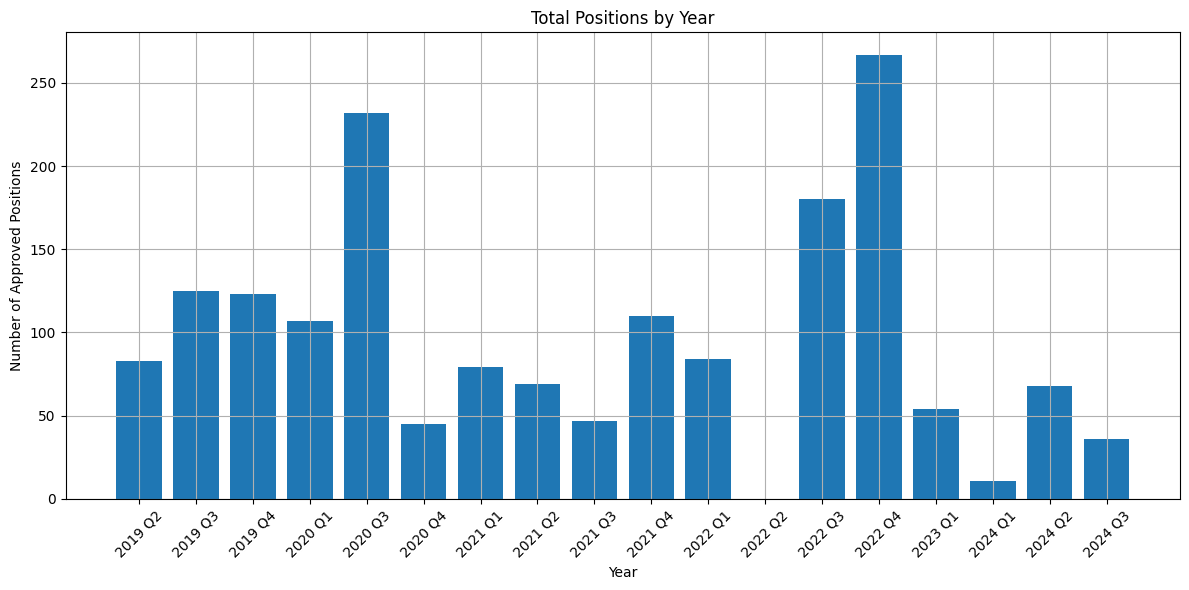

In [9]:
query = f"""
SELECT 
    year,
    quarter,
    SUM(approved_positions) AS approved_positions
FROM employers e
WHERE (e.occupation LIKE '%%oftware%%'
   OR e.occupation LIKE '%%eveloper%%'
   OR e.occupation LIKE '%%rogrammer%%'
   OR e.occupation LIKE '%%atabase%%'
   OR e.occupation LIKE '%%Data Scien%%')
   AND e.employer LIKE '%%Amazon%%'
GROUP BY year, quarter
ORDER BY year, quarter;
"""

# Load data into a DataFrame
df = pd.read_sql(query, engine).round(2)
df['period'] = df['year'].astype(str) + ' Q' + df['quarter'].astype(str)

plt.figure(figsize=(12, 6))
plt.bar(df['period'], df['approved_positions'])

plt.title('Total Positions by Year')
plt.xlabel('Year')
plt.ylabel('Number of Approved Positions')
plt.xticks(df['period'], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()
